# FIFA 21 players Data Exploration
## by Lyonel

In this document we are exploring a dataset containing information of all 18944 players from the latest edition FIFA 21. Attributes include player's stat and informations such as Club, DateOfBirth, Value, Salary, measures of Attacking, Skills, Defense, etc.


## Investigation Overview

Soccer is one of the most popular sports in the world. Although it is a physical and endurance sport, the technical dimension is emphasized. Just look at the most scrutinized and celebrated players. 
Moreover, the challenge for the teams is to be competitive both sportily and financially. Thus the transfer market is one of the great moments in a season because contracts and salaries are negotiated based on the overall evaluation of the players.

In this study we try to answer 4 major questions:

- Are the most technical players the most offensive players on the field?
- Are there underpaid players considering their overall rating? Are there overpaid players as well?
- What are the major variables that predict a player's salary given the competition for their position?
- Which teams overpay their players considering their overall rating?

To answer these questions, we will only focus on field players and will only take into account the physical, technical, contractual and mental factors of the players for our analyses.

In [1]:
# import all packages and set plots to be embedded inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [3]:
df=pd.read_csv('players_21.csv')
players=df.copy()
players.shape

(18944, 106)

## I. Let's explore the data

In [4]:
players.head(1)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,...,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3


In [5]:
# Lets print all column names

col = list(players.columns)
print(col)

['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_ba

In [6]:
# Lets get rid of non physical, technical, contractual and mental factors

variable_of_interest=['sofifa_id', 'short_name', 'age','height_cm', 'weight_kg', 'nationality', 'club_name',
                      'overall','value_eur', 'wage_eur', 'player_positions', 'preferred_foot','weak_foot',
                      'skill_moves','pace', 'shooting', 'passing', 'dribbling', 'defending', 
                      'physic','attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 
                      'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 
                      'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration',
                      'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
                      'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
                      'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 
                      'mentality_penalties', 'mentality_composure', 'defending_marking', 'defending_standing_tackle', 
                      'defending_sliding_tackle']

In [7]:
#Lets drop all variables we don't need

players = players[variable_of_interest]

In [8]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18944 entries, 0 to 18943
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sofifa_id                   18944 non-null  int64  
 1   short_name                  18944 non-null  object 
 2   age                         18944 non-null  int64  
 3   height_cm                   18944 non-null  int64  
 4   weight_kg                   18944 non-null  int64  
 5   nationality                 18944 non-null  object 
 6   club_name                   18719 non-null  object 
 7   overall                     18944 non-null  int64  
 8   value_eur                   18944 non-null  int64  
 9   wage_eur                    18944 non-null  int64  
 10  player_positions            18944 non-null  object 
 11  preferred_foot              18944 non-null  object 
 12  weak_foot                   18944 non-null  int64  
 13  skill_moves                 189

**1. Sofifa has to be converted in string**

In [9]:
players.player_positions.value_counts()

CB             2437
GK             2083
ST             1893
CDM, CM         827
CM              810
               ... 
LW, CF, LM        1
CF, LW, RW        1
LM, RWB, RM       1
RW, CM, CAM       1
LB, RB, RW        1
Name: player_positions, Length: 611, dtype: int64

**2. We have to get rid of all GK positions, since our objective is to examine only field players.**

**3.  We have to clean this features by splitting it. A player can play at many positions.**

**4.  The first positions is the prefered position, we have to convert it to categorical type as well as prefered_foot,**

In [10]:
players[['pace', 'shooting', 'passing', 'dribbling', 'defending','physic','defending_marking']].head(2)

,pace,shooting,passing,dribbling,defending,physic,defending_marking
0,85.0,92.0,91.0,95.0,38.0,65.0,NaN
1,89.0,93.0,81.0,89.0,35.0,77.0,NaN


**5. The first 6 features have to be converted to int. lets investigate the 'defending_marking' variable**

In [11]:
players.isnull().sum() 

sofifa_id                         0
short_name                        0
age                               0
height_cm                         0
weight_kg                         0
nationality                       0
club_name                       225
overall                           0
value_eur                         0
wage_eur                          0
player_positions                  0
preferred_foot                    0
weak_foot                         0
skill_moves                       0
pace                           2083
shooting                       2083
passing                        2083
dribbling                      2083
defending                      2083
physic                         2083
attacking_crossing                0
attacking_finishing               0
attacking_heading_accuracy        0
attacking_short_passing           0
attacking_volleys                 0
skill_dribbling                   0
skill_curve                       0
skill_fk_accuracy           

**6. No data in the 'defending_marking' feature, we have to remove it.**

In [12]:
players[players.pace.isnull()].player_positions.value_counts()

GK    2083
Name: player_positions, dtype: int64

In [248]:
# All missing values in ['pace', 'shooting', 'passing', 'dribbling', 'defending','physic'] correspond to GK players.
# We will get rid of theses players by deleting all GK positions.

In [13]:
players.describe()

,sofifa_id,age,height_cm,weight_kg,overall,value_eur,wage_eur,weak_foot,skill_moves,pace,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
count,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,1.894400e+04,18944.000000,18944.000000,18944.000000,16861.000000,...,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,0.0,18944.000000,18944.000000
mean,226242.402872,25.225823,181.190773,75.016892,65.677787,2.224813e+06,8675.852513,2.936603,2.363017,67.668110,...,46.758763,55.488862,46.250000,50.255807,53.828231,48.050412,57.978674,NaN,47.581767,45.546505
std,27171.091056,4.697354,6.825672,7.057140,7.002278,5.102486e+06,19654.774894,0.667132,0.766469,10.984862,...,19.305319,17.203045,20.738106,19.443738,13.724072,15.671721,12.118390,NaN,21.402461,20.953997
min,41.000000,16.000000,155.000000,50.000000,47.000000,0.000000e+00,0.000000,1.000000,1.000000,25.000000,...,4.000000,9.000000,3.000000,2.000000,9.000000,6.000000,12.000000,NaN,5.000000,4.000000
25%,210030.500000,21.000000,176.000000,70.000000,61.000000,3.000000e+05,1000.000000,3.000000,2.000000,62.000000,...,32.000000,44.000000,25.000000,40.000000,45.000000,38.750000,50.000000,NaN,27.000000,24.000000
50%,232314.500000,25.000000,181.000000,75.000000,66.000000,6.500000e+05,3000.000000,3.000000,2.000000,68.000000,...,51.000000,58.000000,52.000000,55.000000,55.000000,49.000000,59.000000,NaN,55.000000,52.000000
75%,246760.250000,29.000000,186.000000,80.000000,70.000000,1.800000e+06,7000.000000,3.000000,3.000000,75.000000,...,62.000000,68.000000,64.000000,64.000000,64.000000,60.000000,66.000000,NaN,65.000000,63.000000
max,258970.000000,53.000000,206.000000,110.000000,93.000000,1.055000e+08,560000.000000,5.000000,5.000000,96.000000,...,94.000000,96.000000,91.000000,95.000000,95.000000,92.000000,96.000000,NaN,93.000000,90.000000


**7. We have to clean players with wage_eur and value_eur == 0.**

## II. Let's clean the data

In [14]:
#1. Sofifa has to be converted in string
players['sofifa_id']=players['sofifa_id'].astype(str)

In [15]:
#2. We have to get rid of all GK positions, since our objective is to examine only field players.
players=players[players.player_positions != 'GK']

In [16]:
#3. We have to clean this features by splitting it. A player can play at many positions.

players.player_positions=players.player_positions.str.replace(' ', '')
new_player_position = players['player_positions'].str.get_dummies(sep=',').add_prefix('position_')
players =  pd.concat([players,new_player_position],axis = 1)

In [17]:
#4. The first positions is the prefered position, we have to convert it to categorical type as well as prefered_foot,
#club_name,nationality

players['player_positions']=players.player_positions.str.split(',', expand=True)[0]

cat_var=['player_positions','preferred_foot','club_name','nationality']
for var in cat_var:
    players[var]=players[var].astype('category')

players.player_positions.cat.set_categories(
        new_categories = ['CB','LB','RB','LWB','RWB','CDM','CM','LM','RM','CAM','LW','RW','CF','ST'],
        ordered = True, inplace = True
)

In [18]:
#5. The first 6 features have to be converted to int.
cont_var= ['pace', 'shooting', 'passing', 'dribbling', 'defending','physic']
for var in cont_var:
    players[var]=players[var].astype(np.int64)

In [19]:
#6. No data in the 'defending_marking' feature, we have to remove it.
players.drop('defending_marking',axis=1,inplace=True)

In [21]:
#7. We have to clean players with wage_eur and value_eur == 0.

filt=(players.value_eur==0) | (players.wage_eur==0)
players=players[~filt]

In [22]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16654 entries, 0 to 18943
Data columns (total 63 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   sofifa_id                   16654 non-null  object  
 1   short_name                  16654 non-null  object  
 2   age                         16654 non-null  int64   
 3   height_cm                   16654 non-null  int64   
 4   weight_kg                   16654 non-null  int64   
 5   nationality                 16654 non-null  category
 6   club_name                   16654 non-null  category
 7   overall                     16654 non-null  int64   
 8   value_eur                   16654 non-null  int64   
 9   wage_eur                    16654 non-null  int64   
 10  player_positions            16653 non-null  category
 11  preferred_foot              16654 non-null  category
 12  weak_foot                   16654 non-null  int64   
 13  skill_moves     

### The structure of the dataset

The final dataset contains 16654 players and 63 features. We have removed the players who play as goalkeepers because this requires taking into account other variables that are completely different from those of the outfield players. Most of the features relating to the player's evaluation are measured on the scale of **100 points**. Those variables are : **'potential','pace', 'shooting','passing', 'dribbling'. etc.** <br> <br>
(worst) **0 ——> 100** (best)<br>

In [23]:
# Some adjustments before answering questions
# graphical context setting

my_color=['#CE050F','#00D38D','#FFDF01']
sb.set(context='notebook', style='white', palette=my_color, font='sans-serif', color_codes=False, 
       rc={"axes.titlesize":15, "axes.titleweight":'bold',"axes.labelsize":11.5,"axes.labelweight":'bold'})


## Q1. Technical skills by player's position

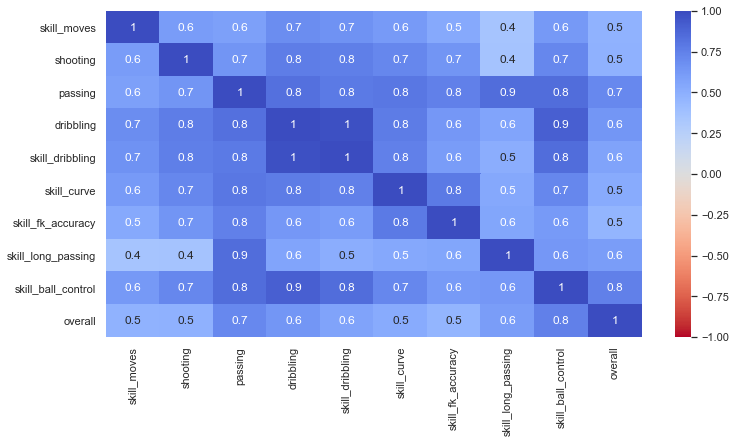

In [24]:
#Lets find the two best tehnique's features in relation to overall rating of a player

tech_features=[       'skill_moves','shooting', 'passing', 'dribbling',
                      'skill_dribbling', 'skill_curve', 
                      'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
              'overall']

plt.figure(figsize=(12, 6))
sb.heatmap(players[tech_features].corr(), annot = True, fmt='.1g',vmin=-1, center=0,vmax=1,cmap="coolwarm_r");

In [25]:
players[tech_features].corr()['overall'].sort_values(ascending=False).head()

overall               1.000000
skill_ball_control    0.754158
passing               0.712244
dribbling             0.642428
skill_long_passing    0.608453
Name: overall, dtype: float64

 According to the heatmap, the two best tehnique's features in relation to overall rating are : 
 **skill_ball_conrol** and **passing**. Lets answer the question.

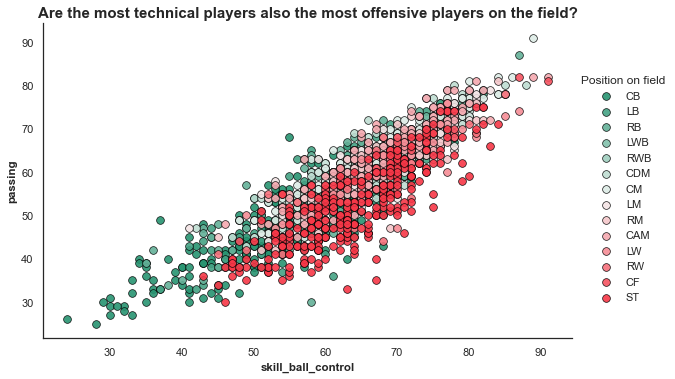

In [26]:
custom_palette = sb.diverging_palette(155, 10, s=90, l=55, n=14,)
dat=players.sample(players.shape[0]//10)
g = sb.lmplot(x='skill_ball_control', y="passing", hue="player_positions", data=dat, 
                    aspect=1.6, robust=True, palette=custom_palette,fit_reg=False, 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black',alpha=.9));
plt.title("Are the most technical players also the most offensive players on the field?");
g._legend.set_title('Position on field');

According to this graph confirms players playing lower on the field (i.e. defensive players) are less technically skilled than others. This is because their position does not require them to be very creative on the field.However, there are a few exceptions, as there are players who play defensive positions but are very technically skilled. The opposite is also true, but to a lesser extent.<br><br>
**Meanings of the players positions**<br>
CAM - Central attacking midfielder
CB - Centre back
CDM - Central defensive midfielder
CF - Center forward
CM - Centre midfielder
GK - Goalkeeper
LB - Left back
LM - Left midfielder
LW - Left winger (typically more attack-minded than a left midfielder)
RB - Right back
RM - Right midfielder
RW - Right winger (a more attacking option than a right midfielder)
ST - Striker<br><br>
**CB --> LB --> RB --> LWB --> RWB --> CDM --> CM --> LM --> RM --> CAM --> LW --> RW --> CF --> ST** <br>
(Low on the field) -----------> (High on the field)

## Q2. Player's overal ratings by positions and wage

In [27]:
# Let's create a new feature to separate the players with wage above the median and the others

smed=players.wage_eur.median()
above_median_wage=players.wage_eur > smed
players['above_median_wage']=above_median_wage

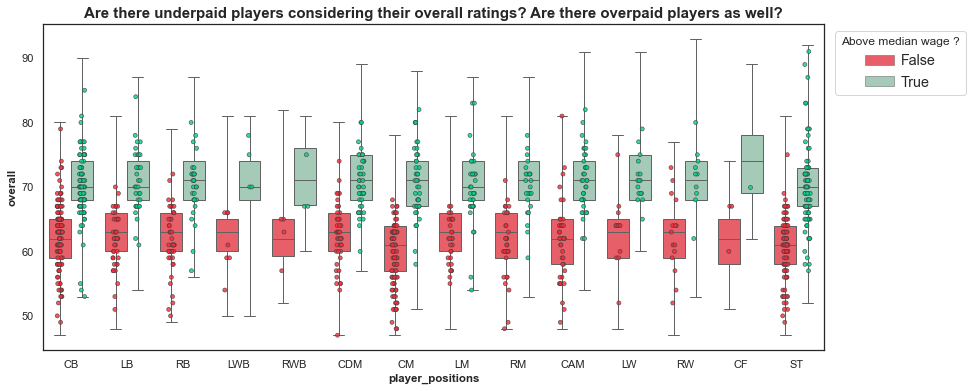

In [28]:
plt.figure(figsize=(14,6))
my_color=['#fe2836','#00D38D']
mac=['#fe4854','#9fd0b7']
ax = sb.boxplot(x="player_positions", y="overall", data=players, whis=np.inf,color="w",palette=mac,linewidth=1,hue='above_median_wage')

ax = sb.stripplot(x="player_positions", y="overall",palette=my_color,hue='above_median_wage',
                  data=players.sample(1000),jitter=True,size=4,linewidth=.7,alpha=0.8,dodge=True,color='gray')

plt.legend(bbox_to_anchor=(1.005, 1), loc=2,title="Above median wage ?");
ax.set_title("Are there underpaid players considering their overall ratings? Are there overpaid players as well?");

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles[0:2], labels[0:2],
               bbox_to_anchor=(1.005, 1), loc=2,
               fontsize='large',title="Above median wage ?",
               handletextpad=0.5)
lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [40]

According to this graph,the highest paid players in each position are, on average, those with the highest potential (the median of these players is always higher than that of the other group).However, on each position we can find some exceptions. There are many players who are currently underpaid considering the median salary at their position and there are also players who are overpaid compared to the competition at their position. Let's see exactly who they are: 

In [92]:
def over_under_paid(data=players,position='ST',option ='over'):
    '''
    INPUT:
    data - the main datasets 
    position - the player's position
    option - 'over' to display overpaid players  or 'under'for underpaid players
    
    OUTPUT:
    result - a dataframe that contains over/underpaid players.
    
    provides a dataset that contains the over/underpaid players displayed from the highest overall rating to the lowest.
    
    '''
    
    
    var_to_display = ['sofifa_id', 'short_name', 'age','club_name','overall','wage_eur']
    
    
    if(option =='under'):
        median_overal = data[data.above_median_wage == True].groupby(['player_positions']).overall.median()[position]
        filt = (data.overall > median_overal) & (data.above_median_wage == False) & (data.player_positions == position)
    else :
        median_overal = data[data.above_median_wage == False].groupby(['player_positions']).overall.median()[position]
        filt = (data.overall < median_overal) & (players.above_median_wage == True) & (players.player_positions == position)
            
    result = data.loc[filt,var_to_display]
    
    print('---------------------------------------------------------------------------------')
    print("The median overal rating for the {} position is {}".format(position,median_overal))
    
    return result.sort_values(by='overall', ascending=False)
    

In [93]:
# 2 first underpaid players by positions

for pos in players.dropna().player_positions.unique():
    print(over_under_paid(players,pos,'under').head(2))

---------------------------------------------------------------------------------
The median overal rating for the RW position is 71
     sofifa_id     short_name  age             club_name  overall  wage_eur
1108    196069  J. Fuenzalida   35  Universidad Católica       77       500
1795    163925    A. Diamanti   37     Western United FC       75      3000
---------------------------------------------------------------------------------
The median overal rating for the ST position is 70
    sofifa_id     short_name  age         club_name  overall  wage_eur
365    230430    Oswaldinato   28          Flamengo       81       500
678    243238  Júnior Moraes   33  Shakhtar Donetsk       79       500
---------------------------------------------------------------------------------
The median overal rating for the LW position is 71
    sofifa_id        short_name  age  club_name  overall  wage_eur
887    230385  Albertinho Dutra   28  São Paulo       78       500
892    230460      Prazera

## Q3. Player's salary prediction

Let's find out the best features that predict a player's `real salary`. By real salary we mean the salary that a player should receive based only on an assessment of his physical, technical and mental abilities regardless of contractual implications.

In [96]:
# Let's select all the physical, technical, mental features

variable_of_interest=['age', 'height_cm','weight_kg','weak_foot', 'skill_moves',
                       'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
                       'attacking_crossing', 'attacking_finishing',
                       'attacking_heading_accuracy', 'attacking_short_passing',
                       'attacking_volleys', 'skill_dribbling', 'skill_curve',
                       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
                       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
                       'movement_reactions', 'movement_balance', 'power_shot_power',
                       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                       'mentality_aggression', 'mentality_interceptions',
                       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
                       'mentality_composure', 'defending_standing_tackle',
                       'defending_sliding_tackle']

X = players[variable_of_interest]
y = players['wage_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=12)


#Instantiate
model = LinearRegression(normalize=True) 

#Fit 
model.fit(X_train, y_train) 

#Predict
y_pred=model.predict(X_test)

#Score
r2_test=r2_score(y_test, y_pred)
r2_test

0.3220440516997295

Our model is **32%** reliable.

In [95]:
# A function to display the best coefs 

def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = model.coef_
    coefs_df['abs_coefs'] = np.abs(model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df.reset_index(drop=True)

#Use the function
coef_df = coef_weights(model.coef_, X_train)

#A quick look at the top 5 best features to prédict salary
coef_df.head(5)

,est_int,coefs,abs_coefs
0,skill_moves,2649.145699,2649.145699
1,dribbling,-998.136029,998.136029
2,passing,904.129004,904.129004
3,movement_reactions,777.876722,777.876722
4,skill_ball_control,534.989691,534.989691


## Q4. Which teams are overpaying their players compared to the predicted salary?

In [97]:
# Predict salaries

y_p=model.predict(X)
players['salary_pred']=np.round(y_p,2)

In [98]:
# display the Top 5 club 

import warnings
warnings.filterwarnings('ignore')

temp=players.groupby('club_name')['wage_eur','salary_pred'].sum()
temp['overpayment']=temp.wage_eur - temp.salary_pred
temp.sort_values('overpayment',ascending=False).head()

,wage_eur,salary_pred,overpayment
club_name,,,
Real Madrid,4525000,968160.32,3556839.68
FC Barcelona,4353000,1020658.20,3332341.80
Manchester City,3469000,949002.84,2519997.16
Liverpool,2877000,978824.49,1898175.51
Inter,2589000,924165.64,1664834.36


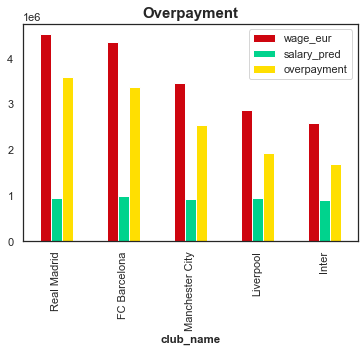

In [280]:
temp.sort_values('overpayment',ascending=False).head().plot(kind='bar');
plt.title("Overpayment");

It appears that the teams that overpay their players regarding the predictions made are the biggest European clubs. This is not surprising because the massive competition that these teams face is such that they are constantly adjusting their rosters in order to have the best team. And this leads to overpaying for some players.